<a href="https://colab.research.google.com/github/FTDS-assignment-bay/github-classroom-exercise-Itsukiyaki/blob/main/P1G5_eldi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pendahuluan
---
Nama  : Eldi Muhamad Sunartadirja
Batch : RMT-040

Problem Statement:  
Perusahaan e-commerce menghadapi tantangan dalam mengidentifikasi pengguna baru yang berpotensi melakukan pembelian di masa mendatang. Saat ini, strategi pemasaran masih bersifat umum dan kurang terfokus, sehingga menyebabkan efisiensi promosi yang rendah. Dengan menganalisis data perilaku pengguna dari Google Analytics, diperlukan model Machine Learning yang dapat memprediksi kemungkinan konversi pengguna baru menjadi pelanggan.  

Objektive:  
Perusahaan e-commerce menghadapi tantangan dalam mengidentifikasi pengguna baru yang berpotensi melakukan pembelian di masa mendatang. Saat ini, strategi pemasaran masih bersifat umum dan kurang terfokus, sehingga menyebabkan efisiensi promosi yang rendah. Dengan menganalisis data perilaku pengguna dari Google Analytics, diperlukan model Machine Learning yang dapat memprediksi kemungkinan konversi pengguna baru menjadi pelanggan.

---

## Query SQL

In [4]:
from google.colab import auth
from google.cloud import bigquery


auth.authenticate_user()
print('Authenticated')

project_id = "ftds-eldi"
client = bigquery.Client(project=project_id)

Authenticated


In [5]:
df_ori = client.query('''
SELECT * EXCEPT(fullVisitorId)

FROM
  # Select the features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1 # New visitor only
    AND date BETWEEN '20160801' AND '20170531') # Only the first 10 months of data will be used

JOIN
  (SELECT
    fullvisitorid,
    # Create the target
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)

USING (fullVisitorId);

''').to_dataframe()

In [6]:
# Menyimpan dataset
df_ori.to_csv('dataset_1.csv',index=False)

In [7]:
df_ori2 = client.query('''

WITH all_visitor_stats AS (
   SELECT
      fullvisitorid,
      -- 1. Create a label or target column named `will_buy_on_return_visit`
      CASE
         WHEN SUM(totals.transactions) > 0 THEN 1
         ELSE 0
      END AS will_buy_on_return_visit
   FROM `data-to-insights.ecommerce.web_analytics`
   GROUP BY fullvisitorid
)

SELECT * EXCEPT(unique_session_id)
FROM (
   SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      will_buy_on_return_visit,

      -- 2. Convert `h.eCommerceAction.action_type` to an integer
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,

      -- User behavior on the website
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,

      -- Source of the visitors
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,

      -- Device information
      device.deviceCategory,

      -- User geography
      IFNULL(geoNetwork.country, "Unknown") AS country

   FROM `data-to-insights.ecommerce.web_analytics`,
        UNNEST(hits) AS h

   JOIN all_visitor_stats USING(fullvisitorid)

   WHERE
      totals.newVisits = 1
      -- 3. Use data from the date range '20160801' to '20170531'
      AND date BETWEEN '20160801' AND '20170531'

   GROUP BY
      unique_session_id,
      will_buy_on_return_visit,
      bounces,
      time_on_site,
      totals.pageviews,
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      device.deviceCategory,
      country
);

''').to_dataframe()

In [8]:
# Menyimpan Dataset
df_ori2.to_csv('dataset_2.csv',index=False)

## Import Libraries

In [11]:
!pip install feature_engine
!pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 7.4 MB/s eta 0:00:00


In [13]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, kstest, skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
import phik
import pickle
import json

## Data Loading

In [14]:
# Load Dataset
df_set_1 = pd.read_csv('dataset_1.csv')
df_set_1

,bounces,time_on_site,will_buy_on_return_visit
0,1,0,0
1,0,539,0
2,0,72,0
3,0,823,0
4,1,0,0
...,...,...,...
623996,0,517,0
623997,0,72,0
623998,0,61,0
623999,0,51,0


In [15]:
# Load Dataset
df_set_2 = pd.read_csv('dataset_2.csv')
df_set_2

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,54,5.0,(direct),(none),Direct,desktop,Argentina
1,0,0,0,167,5.0,(direct),(none),Direct,mobile,India
2,0,0,0,184,5.0,google,organic,Organic Search,desktop,Ireland
3,0,0,0,141,5.0,google,organic,Organic Search,desktop,Belarus
4,0,0,0,715,5.0,google,organic,Organic Search,desktop,Israel
...,...,...,...,...,...,...,...,...,...,...
623935,0,0,0,72,3.0,youtube.com,referral,Social,desktop,Canada
623936,0,0,0,48,3.0,youtube.com,referral,Social,mobile,United States
623937,0,0,0,102,2.0,youtube.com,referral,Social,desktop,Netherlands
623938,0,0,0,40,3.0,youtube.com,referral,Social,tablet,United States


## Exploratory Data Analysis (EDA)

### Dataset 1

In [16]:
df_set_1.head(10)

,bounces,time_on_site,will_buy_on_return_visit
0,1,0,0
1,0,539,0
2,0,72,0
3,0,823,0
4,1,0,0
5,0,160,0
6,0,547,0
7,0,322,0
8,0,1516,0
9,0,51,0


Data pada kolom `bounces` dan `will_buy_on_return_visit` berbentuk binary. `bounces` dan `will_buy_on_return_visit`  bersifat Categorical Nominal, sedangkan `time_on_site` bersifat Numerical Continous.

In [17]:
df_set_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624001 entries, 0 to 624000
Data columns (total 3 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   bounces                   624001 non-null  int64
 1   time_on_site              624001 non-null  int64
 2   will_buy_on_return_visit  624001 non-null  int64
dtypes: int64(3)
memory usage: 14.3 MB


In [18]:
df_set_1.columns

Index(['bounces', 'time_on_site', 'will_buy_on_return_visit'], dtype='object')

In [19]:
df_set_1.shape

(624001, 3)

In [20]:
df_set_1.isnull().sum()

,0
bounces,0
time_on_site,0
will_buy_on_return_visit,0


Tidak ditemukan missing value pada dataset 1.

In [21]:
df_set_1.describe()

,bounces,time_on_site,will_buy_on_return_visit
count,624001.000000,624001.000000,624001.000000
mean,0.500844,120.897494,0.015460
std,0.500000,331.077426,0.123373
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,81.000000,0.000000
max,1.000000,15047.000000,1.000000


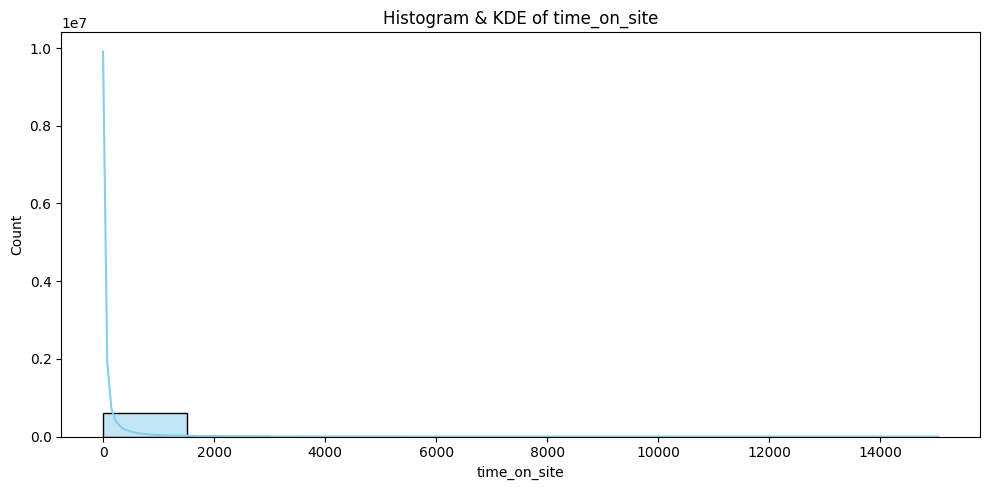

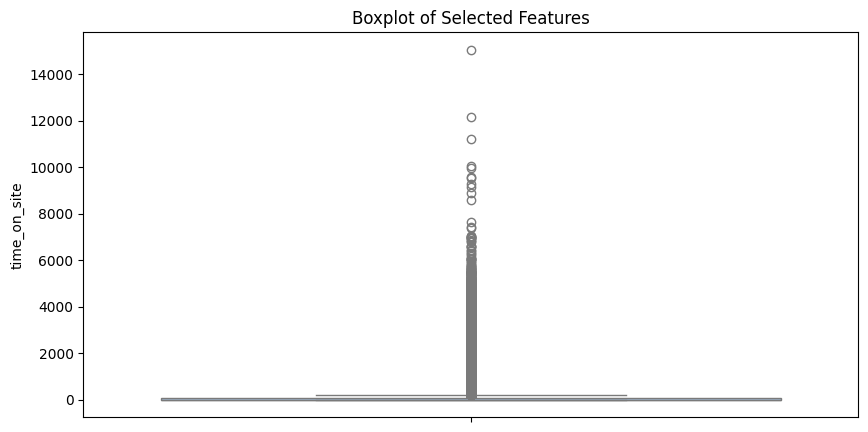


Feature: time_on_site
Shapiro-Wilk Test: Statistic=0.39663595675599783, p-value=1.42365466418247e-210
Kolmogorov-Smirnov Test: Statistic=0.3574945662652548, p-value=0.0
Data is likely not normally distributed (p < 0.05)


In [22]:
# Histogram + KDE
plt.figure(figsize=(10, 5))
plt.subplot(1,1,1)
sns.histplot(df_set_1['time_on_site'], kde=True, bins=10, color="skyblue")
plt.title(f"Histogram & KDE of {'time_on_site'}")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_set_1['time_on_site'], palette="pastel")
plt.title("Boxplot of Selected Features")
plt.show()

# Shapiro-Wilk and Kolmogorov-Smirnov Tests
data = df_set_1['time_on_site']

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(data)

# Kolmogorov-Smirnov Test
ks_stat, ks_p = kstest(data, "norm", args=(data.mean(), data.std()))

print(f"\nFeature: {'time_on_site'}")
print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:}, p-value={shapiro_p:}")
print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:}, p-value={ks_p:}")

if shapiro_p < 0.05 or ks_p < 0.05:
    print("Data is likely not normally distributed (p < 0.05)")
else:
    print("Data is likely normally distributed (p ≥ 0.05)")

Dataset 1 bersifat skewed dan memiliki outlier.

### Dataset 2

In [23]:
df_set_2.head(10)

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,54,5.0,(direct),(none),Direct,desktop,Argentina
1,0,0,0,167,5.0,(direct),(none),Direct,mobile,India
2,0,0,0,184,5.0,google,organic,Organic Search,desktop,Ireland
3,0,0,0,141,5.0,google,organic,Organic Search,desktop,Belarus
4,0,0,0,715,5.0,google,organic,Organic Search,desktop,Israel
5,0,0,0,41,5.0,(direct),(none),Direct,desktop,United States
6,0,0,0,14,3.0,google,organic,Organic Search,desktop,Australia
7,0,0,0,1469,5.0,google,organic,Organic Search,desktop,Italy
8,0,0,0,1058,5.0,(direct),(none),Direct,mobile,Switzerland
9,0,0,0,211,5.0,google,organic,Organic Search,desktop,India


In [24]:
df_set_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623940 entries, 0 to 623939
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   will_buy_on_return_visit   623940 non-null  int64  
 1   latest_ecommerce_progress  623940 non-null  int64  
 2   bounces                    623940 non-null  int64  
 3   time_on_site               623940 non-null  int64  
 4   pageviews                  623926 non-null  float64
 5   source                     623940 non-null  object 
 6   medium                     623940 non-null  object 
 7   channelGrouping            623940 non-null  object 
 8   deviceCategory             623940 non-null  object 
 9   country                    623940 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 47.6+ MB


In [25]:
df_set_2.columns

Index(['will_buy_on_return_visit', 'latest_ecommerce_progress', 'bounces',
       'time_on_site', 'pageviews', 'source', 'medium', 'channelGrouping',
       'deviceCategory', 'country'],
      dtype='object')

In [26]:
df_set_2.shape

(623940, 10)

In [27]:
df_set_2.isnull().sum()

,0
will_buy_on_return_visit,0
latest_ecommerce_progress,0
bounces,0
time_on_site,0
pageviews,14
source,0
medium,0
channelGrouping,0
deviceCategory,0
country,0


In [28]:
df_set_2.describe()

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews
count,623940.000000,623940.000000,623940.000000,623940.000000,623926.000000
mean,0.026193,0.405569,0.500795,120.909313,3.791554
std,0.159710,1.106166,0.500000,331.091452,6.697414
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,81.000000,4.000000
max,1.000000,6.000000,1.000000,15047.000000,466.000000


1. Apakah fitur bounces, time_on_site, dan pageviews memiliki pengaruh yang cukup tinggi untuk memprediksi target will_buy_on_return_visit? (Gunakan Python untuk menjawab pertanyaan ini)

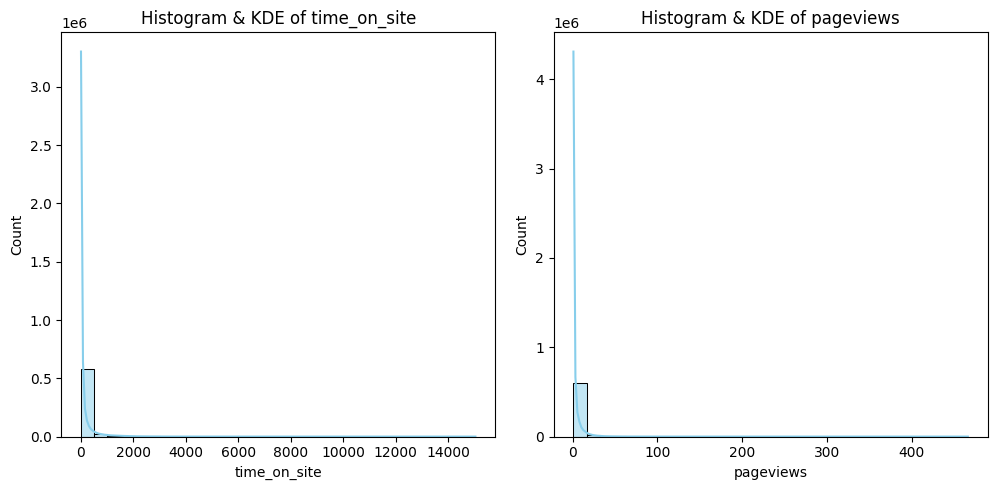

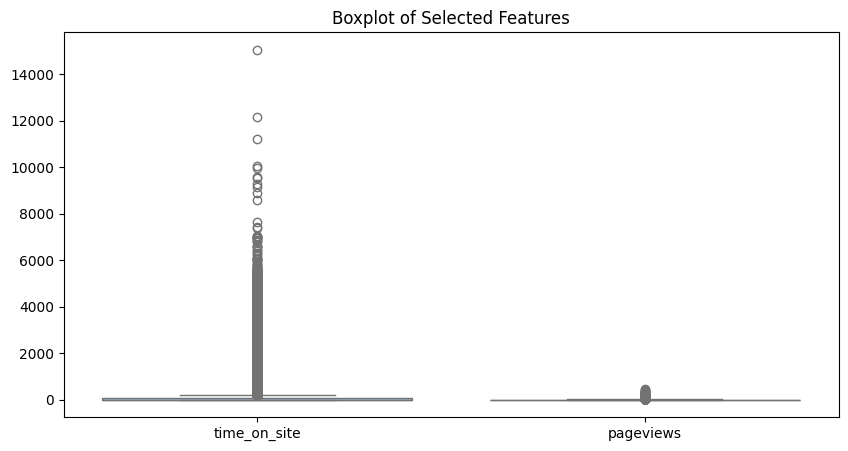


Feature: time_on_site
Shapiro-Wilk Test: Statistic=0.39665701400338405, p-value=1.4340269884618207e-210
Kolmogorov-Smirnov Test: Statistic=0.3574870161625369, p-value=0.0
Data is likely not normally distributed (p < 0.05)

Feature: pageviews
Shapiro-Wilk Test: Statistic=0.4338621841826279, p-value=3.821030150117861e-208
Kolmogorov-Smirnov Test: Statistic=0.3384084345091899, p-value=0.0
Data is likely not normally distributed (p < 0.05)


In [29]:
# Memilih features
features = ["time_on_site", "pageviews"]

# Histogram + KDE
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df_set_2[feature], kde=True, bins=30, color="skyblue")
    plt.title(f"Histogram & KDE of {feature}")
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_set_2[features], palette="pastel")
plt.title("Boxplot of Selected Features")
plt.show()

# Shapiro-Wilk and Kolmogorov-Smirnov Tests
for feature in features:
    data = df_set_2[feature].dropna()  # Drop NaN values

    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = shapiro(data)

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = kstest(data, "norm", args=(data.mean(), data.std()))

    print(f"\nFeature: {feature}")
    print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:}, p-value={shapiro_p:}")
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat:}, p-value={ks_p:}")

    if shapiro_p < 0.05 or ks_p < 0.05:
        print("Data is likely not normally distributed (p < 0.05)")
    else:
        print("Data is likely normally distributed (p ≥ 0.05)")


Correlation Matrix:
                           bounces  time_on_site  pageviews  \
bounces                      1.00         -0.37      -0.42   
time_on_site                -0.37          1.00       0.70   
pageviews                   -0.42          0.70       1.00   
will_buy_on_return_visit    -0.15          0.26       0.34   

                          will_buy_on_return_visit  
bounces                                      -0.15  
time_on_site                                  0.26  
pageviews                                     0.34  
will_buy_on_return_visit                      1.00  


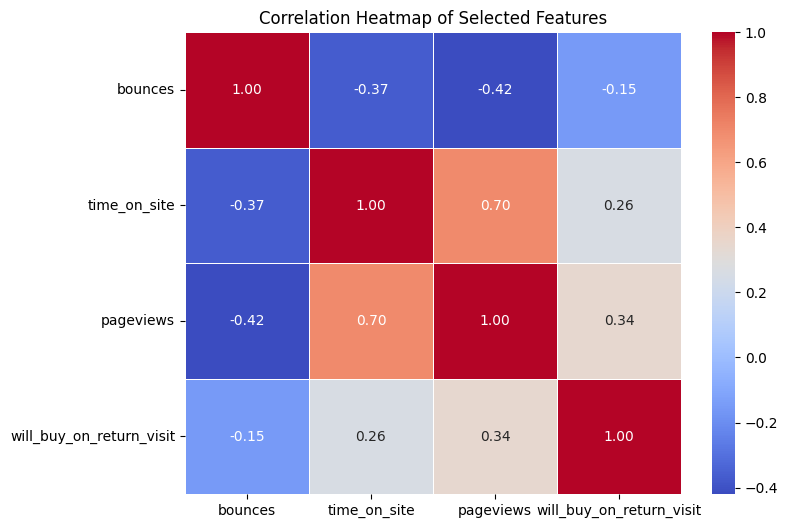

In [30]:
# Select relevant features + target variable
features = ["bounces", "time_on_site", "pageviews", "will_buy_on_return_visit"]

# Compute correlation matrix
corr_matrix = df_set_2[features].corr().round(decimals=2)

# Print correlation values
print("Correlation Matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

Hubungan Antara Fitur dan will_buy_on_return_visit  
- pageviews dan will_buy_on_return_visit (0,34)  
Korelasi positif lemah hingga sedang → Pengguna yang melihat lebih banyak halaman cenderung membeli saat berkunjung lagi.  

- time_on_site dan will_buy_on_return_visit (0,26)  
Korelasi positif lemah → Menghabiskan lebih banyak waktu di situs dikaitkan dengan peluang pembelian yang sedikit lebih tinggi saat berkunjung lagi.

- bounces dan will_buy_on_return_visit (-0,15)  
Korelasi negatif sangat lemah → Jika pengguna keluar, mereka cenderung tidak membeli saat berkunjung lagi.

2. Apa jenis device yang paling sering digunakan oleh user di wilayah Canada yang berpotensi melakukan pembelian saat mengunjungi kembali website tersebut ? (Gunakan Python untuk menjawab pertanyaan ini)

In [31]:
# Filter data for users in Canada who are likely to buy on a return visit
filtered_df = df_set_2[(df_set_2["country"] == "Canada") & (df_set_2["will_buy_on_return_visit"] == 1)]

# Count occurrences of each device type
device_counts = filtered_df["deviceCategory"].value_counts()

# Get the most frequently used device
most_used_device = device_counts.idxmax()
most_used_count = device_counts.max()

# Print results
print(f"The most frequently used device in Canada by users likely to buy on a return visit is: {most_used_device} ({most_used_count} users)")


The most frequently used device in Canada by users likely to buy on a return visit is: desktop (305 users)


## Modeling 1

### Feature Engineering

In [32]:
# Copy dataset 1
df_copy1 = df_set_1.copy()
df_copy1

,bounces,time_on_site,will_buy_on_return_visit
0,1,0,0
1,0,539,0
2,0,72,0
3,0,823,0
4,1,0,0
...,...,...,...
623996,0,517,0
623997,0,72,0
623998,0,61,0
623999,0,51,0


In [33]:
df_copy1.columns

Index(['bounces', 'time_on_site', 'will_buy_on_return_visit'], dtype='object')

In [34]:
# Function to find upper and lower boundaries for skewed distributed variables
# Let's calculate the boundaries outside which sit the outliers for skewed distributions
# Distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [35]:
upper_boundary_time, lower_boundary_time = find_skewed_boundaries(df_copy1, 'time_on_site', 3)
upper_boundary_time, lower_boundary_time

(324.0, -243.0)

In [36]:
# Lets look at the number and percentage of passengers who paid extremely high Fares

print('Total data : {}'.format(len(df_copy1)))
print('Total Outlier   : {}'.format(len(df_copy1[df_copy1['time_on_site'] > upper_boundary_time])))
print('% Outlier : {}'.format(len(df_copy1[df_copy1['time_on_site'] > upper_boundary_time])/len(df_copy1) * 100))

Total data : 624001
Total Outlier   : 61583
% Outlier : 9.86905469702773


In [37]:
# Capping the skewed distribution

winsoriser_time = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['time_on_site'])

df_copy1 = winsoriser_time.fit_transform(df_copy1)

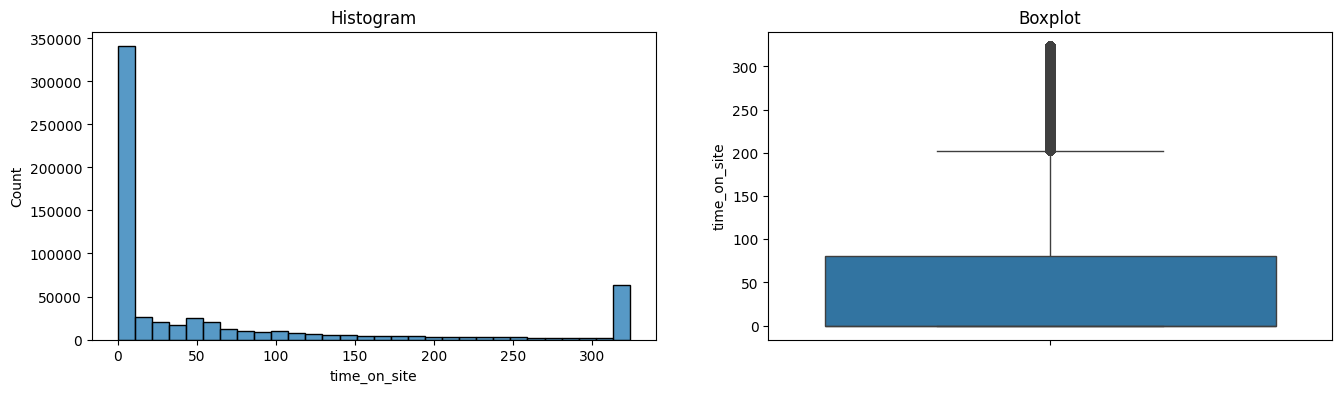

In [38]:
# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

diagnostic_plots(df_copy1, 'time_on_site')

In [39]:
# Split X and y
X = df_copy1.drop(columns=['will_buy_on_return_visit'])
y = df_copy1.will_buy_on_return_visit

print(X.head())
print(y.head())

   bounces  time_on_site
0        1             0
1        0           324
2        0            72
3        0           324
4        1             0
0    0
1    0
2    0
3    0
4    0
Name: will_buy_on_return_visit, dtype: int64


In [40]:
# Split Train Test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=141)
print(f'Train Size: {X_train.shape}')
print(f'Test Size: {X_test.shape}')
X_train.head(5)

Train Size: (499200, 2)
Test Size: (124801, 2)


,bounces,time_on_site
251988,1,0
367036,1,0
305297,1,0
582613,1,0
293923,1,0


In [41]:
num_col = ['time_on_site']
cat_col = []
cat_encode = ['bounces']

In [42]:
scaler = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

preprocess = ColumnTransformer(
    transformers = [
        ('num',scaler,num_col),
        ('cat',ohe,cat_col)],
    remainder='passthrough') # untuk categorical yg sdh di encode

### Model Definition

In [43]:
#Making pipeline for LogReg
pipe_logreg = Pipeline([
('preprocess', preprocess),
('classifier', LogisticRegression())
])

#Making pipeline for Decision Tree
pipe_dt = Pipeline([
('preprocess', preprocess),
('classifier', DecisionTreeClassifier())
])

### Modeling Training

In [44]:
pipe_logreg.fit(X_train, y_train)
print('Training Score: ',round(pipe_logreg.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_logreg.score(X_test, y_test),4))

Training Score:  0.9845
Testing Score:  0.9846


In [45]:
pipe_dt.fit(X_train, y_train)
print('Training Score: ',round(pipe_dt.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_dt.score(X_test, y_test),4))

Training Score:  0.9845
Testing Score:  0.9846


### Model Evaluation

In [46]:
def evaluate_roc_auc(df0, df1):
    score = roc_auc_score(df0, df1)

    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"

In [47]:
y_logreg_pred = pipe_logreg.predict(X_test)
y_logreg_pred

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
# Evaluate Logistic Regression
y_pred_lr = pipe_logreg.predict(X_test)
print('Logistic Regression ROC-AUC:', roc_auc_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
result = evaluate_roc_auc(y_test, y_pred_lr)
print('Hasil dari Evaluasi: ',result)

Logistic Regression ROC-AUC: 0.5
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    122878
           1       0.00      0.00      0.00      1923

    accuracy                           0.98    124801
   macro avg       0.49      0.50      0.50    124801
weighted avg       0.97      0.98      0.98    124801

Hasil dari Evaluasi:  Poor


In [49]:
y_dt_pred = pipe_dt.predict(X_test)
y_dt_pred

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
# Evaluate Decision Tree
y_pred_dt = pipe_dt.predict(X_test)
print('Decision Tree ROC-AUC:', roc_auc_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
result = evaluate_roc_auc(y_test, y_pred_lr)
print('Hasil dari Evaluasi: ',result)

Decision Tree ROC-AUC: 0.5
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    122878
           1       0.00      0.00      0.00      1923

    accuracy                           0.98    124801
   macro avg       0.49      0.50      0.50    124801
weighted avg       0.97      0.98      0.98    124801

Hasil dari Evaluasi:  Poor


## Modeling 2

### Feature Engineering

In [51]:
# Copy dataset 2
df_copy2 = pd.read_csv('dataset_2.csv')
df_copy2

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,54,5.0,(direct),(none),Direct,desktop,Argentina
1,0,0,0,167,5.0,(direct),(none),Direct,mobile,India
2,0,0,0,184,5.0,google,organic,Organic Search,desktop,Ireland
3,0,0,0,141,5.0,google,organic,Organic Search,desktop,Belarus
4,0,0,0,715,5.0,google,organic,Organic Search,desktop,Israel
...,...,...,...,...,...,...,...,...,...,...
623935,0,0,0,72,3.0,youtube.com,referral,Social,desktop,Canada
623936,0,0,0,48,3.0,youtube.com,referral,Social,mobile,United States
623937,0,0,0,102,2.0,youtube.com,referral,Social,desktop,Netherlands
623938,0,0,0,40,3.0,youtube.com,referral,Social,tablet,United States


In [52]:
df_copy2.isnull().sum()

,0
will_buy_on_return_visit,0
latest_ecommerce_progress,0
bounces,0
time_on_site,0
pageviews,14
source,0
medium,0
channelGrouping,0
deviceCategory,0
country,0


In [53]:
df_copy2.dropna(inplace=True)
df_copy2

,will_buy_on_return_visit,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country
0,0,0,0,54,5.0,(direct),(none),Direct,desktop,Argentina
1,0,0,0,167,5.0,(direct),(none),Direct,mobile,India
2,0,0,0,184,5.0,google,organic,Organic Search,desktop,Ireland
3,0,0,0,141,5.0,google,organic,Organic Search,desktop,Belarus
4,0,0,0,715,5.0,google,organic,Organic Search,desktop,Israel
...,...,...,...,...,...,...,...,...,...,...
623935,0,0,0,72,3.0,youtube.com,referral,Social,desktop,Canada
623936,0,0,0,48,3.0,youtube.com,referral,Social,mobile,United States
623937,0,0,0,102,2.0,youtube.com,referral,Social,desktop,Netherlands
623938,0,0,0,40,3.0,youtube.com,referral,Social,tablet,United States


In [54]:
df_copy2.columns

Index(['will_buy_on_return_visit', 'latest_ecommerce_progress', 'bounces',
       'time_on_site', 'pageviews', 'source', 'medium', 'channelGrouping',
       'deviceCategory', 'country'],
      dtype='object')

In [55]:
num_col = ['time_on_site', 'pageviews']
cat_col = ['source', 'medium', 'channelGrouping', 'deviceCategory', 'country']
cat_encode = ['bounces','latest_ecommerce_progress']

In [56]:
# perulangan di dalam kolom kategori
for i in cat_col:
    print(f'Jumlah unique value dari kolom {i} : {df_copy2[i].nunique()}') # menghitung data yg unik dari kolom kategori
    print(f'Unique value dari kolom {i} : {df_copy2[i].unique()}') # menampilkan data kategori yang unik
    print('')

Jumlah unique value dari kolom source : 294
Unique value dari kolom source : ['(direct)' 'google' 'youtube.com' 'dealspotr.com' 'baidu'
 'siliconvalley.about.com' 'yahoo' 'dfa' 'docs.google.com' 'bing' 't.co'
 'sites.google.com' 'googleux.perksplus.com' 'm.facebook.com'
 'newclasses.nyu.edu' 'm.baidu.com' 'groups.google.com'
 'search.tb.ask.com' 'wap.sogou.com' 'duckduckgo.com' 'ask'
 'hangouts.google.com' 'facebook.com' 'mail.google.com' 'phandroid.com'
 'aol' 'arstechnica.com' 'outlook.live.com' 'cases.corp.google.com'
 'productforums.google.com' 'myactivity.google.com' 'businessinsider.com'
 'analytics.google.com' 'reddit.com' 'mall.googleplex.com' 'Partners'
 'moma.corp.google.com' 'int.search.tb.ask.com' 'google.com' 'qiita.com'
 'google.nl' 'seroundtable.com' 'feedly.com' 'gdeals.googleplex.com'
 'sashihara.jp' 'brewmaster.corp.google.com' 'quora.com' 'plus.google.com'
 'blog.golang.org' 'tpc.googlesyndication.com' 'lunametrics.com'
 'google.co.uk' 'google.co.jp' 'web.mail.comcas

In [57]:
df_copy2['source'].value_counts()

,count
source,
google,254629
youtube.com,192496
(direct),98910
mall.googleplex.com,27636
Partners,10421
...,...
redbull.corp.google.com,1
goto.google.com,1
web.whatsapp.com,1


In [58]:
# Membuat grouping berdasarkan keyword pada kolom area
source_keywords = [
                "google","facebook","reddit","yahoo","bing",
                "baidu","youtube","sogou","pinterest","businessinsider",
                "qiita","ask","twitter","mysearch","vk","aol","wow"
                 ]

# Function untuk memendekan nama
def shorten_name(source):
    for keyword in source_keywords:
        if keyword in str(source):  # Memastikan data pada kolom adalah string
            return keyword  # Mengganti keyword
    return source  # Mempertahankan data ketika tidak ditemukan kesesuaian

# Menggunakan function pada kolom source
df_copy2["source"] = df_copy2["source"].apply(shorten_name)

# Mengecek unique value
df_copy2["source"].nunique()

99

In [59]:
df_copy2['country'].value_counts()

,count
country,
United States,219295
India,37413
United Kingdom,25699
Vietnam,22677
Turkey,18215
...,...
American Samoa,1
Norfolk Island,1
St. Martin,1


In [60]:
# Function to find upper and lower boundaries for skewed distributed variables
# Let's calculate the boundaries outside which sit the outliers for skewed distributions
# Distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [61]:
upper_boundary_time, lower_boundary_time = find_skewed_boundaries(df_copy2, 'time_on_site', 3)
upper_boundary_time, lower_boundary_time

(324.0, -243.0)

In [62]:
# Lets look at the number and percentage of passengers who paid extremely high Fares

print('Total data : {}'.format(len(df_copy2)))
print('Total Outlier   : {}'.format(len(df_copy2[df_copy2['time_on_site'] > upper_boundary_time])))
print('% Outlier : {}'.format(len(df_copy2[df_copy2['time_on_site'] > upper_boundary_time])/len(X) * 100))

Total data : 623926
Total Outlier   : 61583
% Outlier : 9.86905469702773


In [63]:
upper_boundary_time, lower_boundary_time = find_skewed_boundaries(df_copy2, 'pageviews', 3)
upper_boundary_time, lower_boundary_time

(13.0, -8.0)

In [64]:
# Lets look at the number and percentage of passengers who paid extremely high Fares

print('Total data : {}'.format(len(df_copy2)))
print('Total Outlier   : {}'.format(len(df_copy2[df_copy2['pageviews'] > upper_boundary_time])))
print('% Outlier : {}'.format(len(df_copy2[df_copy2['pageviews'] > upper_boundary_time])/len(df_copy2) * 100))

Total data : 623926
Total Outlier   : 35586
% Outlier : 5.703560999221061


In [65]:
# Capping the skewed distribution

winsoriser_time = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['time_on_site'])

df_copy2 = winsoriser_time.fit_transform(df_copy2)

In [66]:
# Capping the skewed distribution

winsoriser_page = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=['pageviews'])

df_copy2 = winsoriser_page.fit_transform(df_copy2)

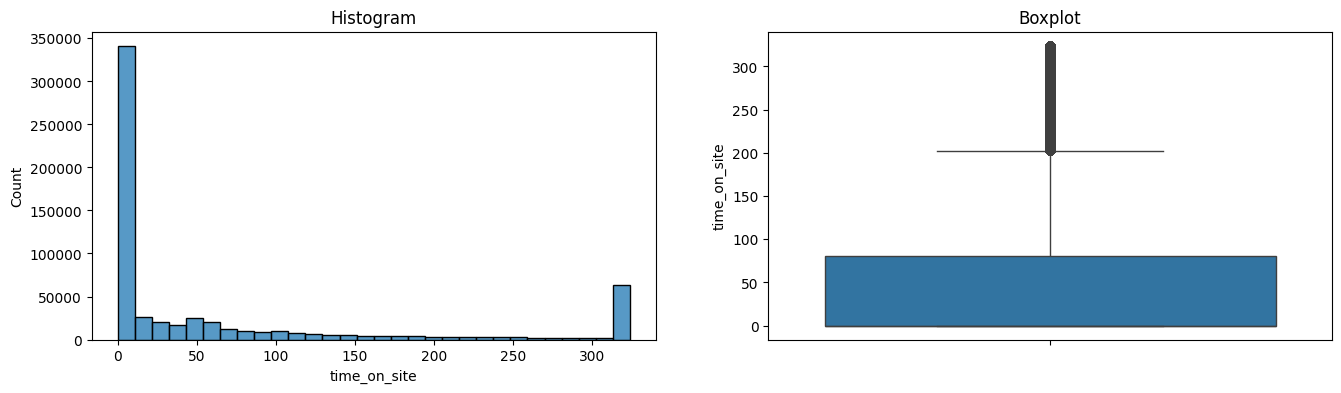

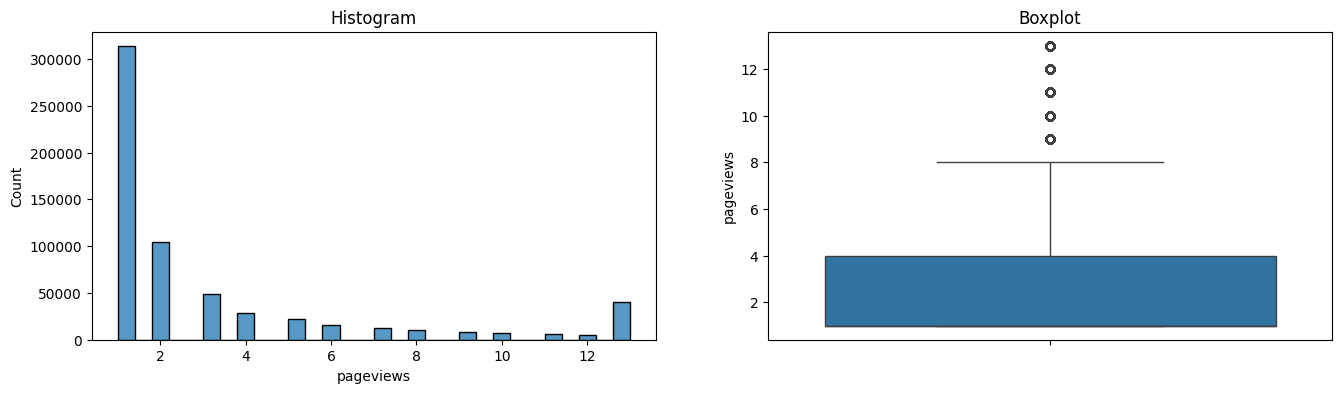

In [67]:
# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

diagnostic_plots(df_copy2, 'time_on_site')
diagnostic_plots(df_copy2, 'pageviews')

In [68]:
X = df_copy2.drop(columns=['will_buy_on_return_visit'])
y = df_copy2.will_buy_on_return_visit

In [69]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=141)
print('Train Size: ', X_train.shape) # menampilkan dimensi data
print('Test Size: ', X_test.shape) # menampilkan dimensi data

Train Size:  (499140, 9)
Test Size:  (124786, 9)


In [70]:
# Concatenate X_train and y_train
concat_train = pd.concat([X_train, y_train], axis=1) #menggabungkan data X_train dan y_train

# Show X_train
concat_train.head()

,latest_ecommerce_progress,bounces,time_on_site,pageviews,source,medium,channelGrouping,deviceCategory,country,will_buy_on_return_visit
47608,0,1,0,1.0,youtube,referral,Social,desktop,Algeria,0
153449,0,0,77,2.0,(direct),(none),Direct,mobile,United States,0
335180,0,1,0,1.0,siliconvalley.about.com,referral,Referral,mobile,Spain,0
285787,0,0,6,2.0,google,organic,Organic Search,desktop,United States,0
371257,0,0,36,3.0,(direct),(none),Direct,tablet,United States,0


In [71]:
concat_train.columns

Index(['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews',
       'source', 'medium', 'channelGrouping', 'deviceCategory', 'country',
       'will_buy_on_return_visit'],
      dtype='object')

In [72]:
# Create function to correlate variables with default
def compute_phik_correlation(dataframe,columns,target):
    subset = dataframe[columns]
    correlation_matrix = subset.phik_matrix()
    return correlation_matrix[target]

# Define the list of columns for each subset
columns = ['latest_ecommerce_progress','bounces','time_on_site','pageviews',
       'source','medium','channelGrouping','deviceCategory','country','will_buy_on_return_visit']
target = ['will_buy_on_return_visit']

# Compute Phi-K correlation for each set of columns and print
correlation = compute_phik_correlation(concat_train, columns, target)

# Print result
print(correlation)

interval columns not set, guessing: ['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews', 'will_buy_on_return_visit']
                           will_buy_on_return_visit
latest_ecommerce_progress                  0.644459
bounces                                    0.225977
time_on_site                               0.355546
pageviews                                  0.448482
source                                     0.168669
medium                                     0.104642
channelGrouping                            0.300094
deviceCategory                             0.044182
country                                    0.255885
will_buy_on_return_visit                   1.000000


Kolom `medium` dan `deviceCategory` dapat di drop, karena memiliki korelasi yang lemah dengan kolom `will_buy_on_return_visit`.

In [73]:
print(X_train.columns)
print(X_test.columns)

Index(['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews',
       'source', 'medium', 'channelGrouping', 'deviceCategory', 'country'],
      dtype='object')
Index(['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews',
       'source', 'medium', 'channelGrouping', 'deviceCategory', 'country'],
      dtype='object')


In [74]:
X_train.drop(['medium','deviceCategory'], axis = 1, inplace = True)
X_test.drop(['medium','deviceCategory'], axis = 1, inplace = True)
print(X_train.columns)
print(X_test.columns)

Index(['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews',
       'source', 'channelGrouping', 'country'],
      dtype='object')
Index(['latest_ecommerce_progress', 'bounces', 'time_on_site', 'pageviews',
       'source', 'channelGrouping', 'country'],
      dtype='object')


### Model Definition

In [75]:
num_col = ['time_on_site','pageviews']
cat_col = ['source','channelGrouping','country']
cat_encode = ['bounces','latest_ecommerce_progress']

scaler = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

preprocess = ColumnTransformer(
    transformers = [
        ('num',scaler,num_col),
        ('cat',ohe,cat_col)],
    remainder='passthrough' # untuk categorical yg sdh di encode
)

In [76]:
# #Making pipeline for LogReg
pipe_log = make_pipeline(preprocess,LogisticRegression(max_iter=100))

# #Making pipeline for Decision Tree
pipe_dt = make_pipeline(preprocess,DecisionTreeClassifier(random_state=141))

### Model Training

In [77]:
pipe_log.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['time_on_site',
                                                   'pageviews']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['source', 'channelGrouping',
                                                   'country'])])),
                ('logisticregression', LogisticRegression())])

In [78]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['time_on_site',
                                                   'pageviews']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['source', 'channelGrouping',
                                                   'country'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=141))])

### Model Evaluation

In [79]:
def evaluate_roc_auc(df0, df1):
    score = roc_auc_score(df0, df1)

    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"

In [80]:
# Evaluate Logistic Regression
y_pred_lr = pipe_log.predict(X_test)
print('Logistic Regression ROC-AUC:', roc_auc_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
result = evaluate_roc_auc(y_test, y_pred_lr)
print('Hasil dari Evaluasi: ',result)

Logistic Regression ROC-AUC: 0.7531241896105998
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121463
           1       0.80      0.51      0.62      3323

    accuracy                           0.98    124786
   macro avg       0.89      0.75      0.81    124786
weighted avg       0.98      0.98      0.98    124786

Hasil dari Evaluasi:  Decent


In [81]:
# Evaluate Decision Tree
y_pred_dt = pipe_dt.predict(X_test)
print('Decision Tree ROC-AUC:', roc_auc_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
result = evaluate_roc_auc(y_test, y_pred_dt)
print('Hasil dari Evaluasi: ',result)

Decision Tree ROC-AUC: 0.7418762544811501
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121463
           1       0.79      0.49      0.60      3323

    accuracy                           0.98    124786
   macro avg       0.89      0.74      0.80    124786
weighted avg       0.98      0.98      0.98    124786

Hasil dari Evaluasi:  Decent


In [82]:
# setting kfold
skfold = StratifiedKFold(n_splits = 5)

# Cross Validation untuk setiap model
cv_log_model = cross_val_score(pipe_log, X_train, y_train, cv = skfold, scoring='roc_auc', n_jobs=-1) # n_jobs untuk melakukan kerjaan secara paralel, -1 menggunakan seluruh processor
cv_dt_model = cross_val_score(pipe_dt, X_train, y_train, cv = skfold, scoring='roc_auc', n_jobs=-1)

In [83]:
# Finding Best Model based on Cross_Val_Score (mean)
name_model = []
cv_scores = 0
for cv,name in zip([cv_log_model,cv_dt_model],
                   ['log_model','dt_model']):
  print(name)
  print('ROC-AUC - All - Cross Validation :', cv)
  print('ROC-AUC - Mean - Cross Validation :', cv.mean())
  print('ROC-AUC - std - Cross Validation :', cv.std())
  print('ROC-AUC - Range of Test Set :', (cv.mean()-cv.std()), '-' , (cv.mean()+cv.std()))
  print('-'*50)
  if cv.mean() > cv_scores:
    cv_scores = cv.mean()
    name_model = name
  else:
    pass
print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', cv_scores)

log_model
ROC-AUC - All - Cross Validation : [0.96392554 0.96186867 0.96088853 0.96098031 0.96175447]
ROC-AUC - Mean - Cross Validation : 0.9618835031756522
ROC-AUC - std - Cross Validation : 0.0010947601103910181
ROC-AUC - Range of Test Set : 0.9607887430652612 - 0.9629782632860432
--------------------------------------------------
dt_model
ROC-AUC - All - Cross Validation : [0.86532486 0.8518078  0.85771847 0.85801633 0.85295825]
ROC-AUC - Mean - Cross Validation : 0.8571651404746927
ROC-AUC - std - Cross Validation : 0.004775159641207633
ROC-AUC - Range of Test Set : 0.852389980833485 - 0.8619403001159004
--------------------------------------------------
Best Model: log_model
Cross Val Mean from Best Model: 0.9618835031756522


In [84]:
y_pred_train = pipe_log.predict(X_train)
y_pred_test = pipe_log.predict(X_test)

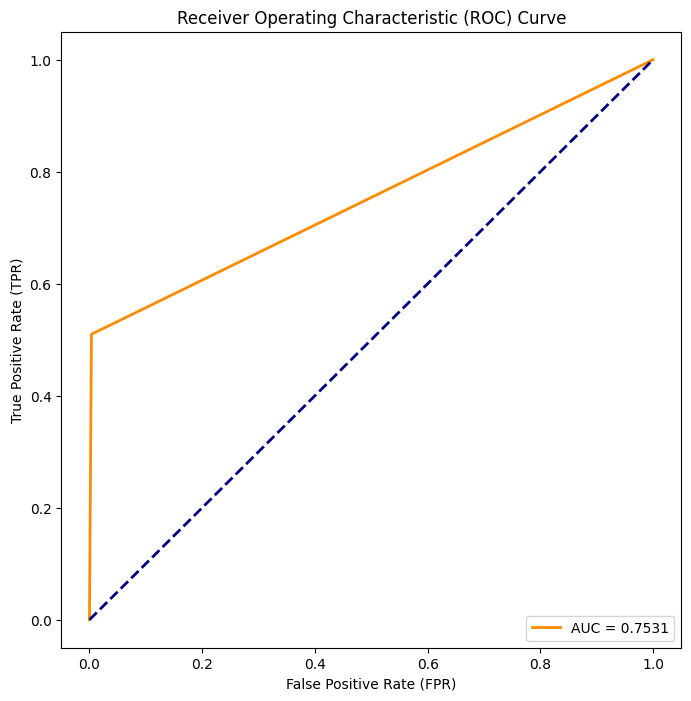

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the metrics for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [86]:
# Create function to create reports
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
    # Calculate roc-auc scores
    score_reports = {
        'ROC-AUC Train Set': roc_auc_score(y_train, y_pred_train),
        'ROC-AUC Test Set': roc_auc_score(y_test, y_pred_test),
    }

    # Store the report in the dictionary with the specified model name
    all_reports[name] = score_reports
    return all_reports

all_reports = {}
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Logistic without Tuning')

pd.DataFrame(all_reports)

,Logistic without Tuning
ROC-AUC Train Set,0.751564
ROC-AUC Test Set,0.753124


## Modeling 3

### Hyperparameter Tuning - Training

In [87]:
# Hyperparameter Tuning : Random Search

# Define Hyperparameters
n_estimators = [50, 100, 200]
max_depth = [5, 10, 20]
min_samples_split = [5, 10]
min_samples_leaf = [5, 10]
random_search_params = {'n_estimators': n_estimators,
                        'max_depth':max_depth,
                        'min_samples_split':min_samples_split,
                        'min_samples_leaf':min_samples_leaf}
random_search_params

{'n_estimators': [50, 100, 200],
 'max_depth': [5, 10, 20],
 'min_samples_split': [5, 10],
 'min_samples_leaf': [5, 10]}

In [89]:
# Train with Random Search
random_search_params = {
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']
}
log_randomcv = RandomizedSearchCV(estimator=pipe_log,
                                 param_distributions=random_search_params,
                                 n_iter=5,
                                 cv=3,
                                 random_state=46,
                                 n_jobs=-1,
                                 scoring='roc_auc')
log_randomcv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['time_on_site',
                                                                                'pageviews']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['source',
                                                                                'channelGrouping',
                                                                                'country'])])),
                                             ('logisticregression',
                                              LogisticRegression())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.01, 0.1, 1,
                                                                  10],
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'logisticregression__solver': ['liblinear']},
                   random_state=46, scoring='roc_auc')

In [90]:
# Best hyperparameters for Logistic Regression
print('Best hyperparameters for Logistic Regression:', log_randomcv.best_params_)

# Best ROC-AUC for Logistic Regression
print('Best ROC-AUC for Logistic Regression:', log_randomcv.best_score_)

# Save best Logistic Regression model to a variable
best_log_model = log_randomcv.best_estimator_

Best hyperparameters for Logistic Regression: {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 1}
Best ROC-AUC for Logistic Regression: 0.9622098979182855


### Hyperparameter Tuning - Evaluation

In [91]:
# Get predictions for training and testing set using the hyperparameter tuned model
y_pred_train_tuned = best_log_model.predict(X_train)
y_pred_test_tuned = best_log_model.predict(X_test)

In [92]:
# Print recall score
print('ROC-AUC - Train Set  : ', roc_auc_score(y_train, y_pred_train_tuned))
print('ROC-AUC - Test Set   : ', roc_auc_score(y_test, y_pred_test_tuned))

ROC-AUC - Train Set  :  0.7519055193365998
ROC-AUC - Test Set   :  0.7535714724686318


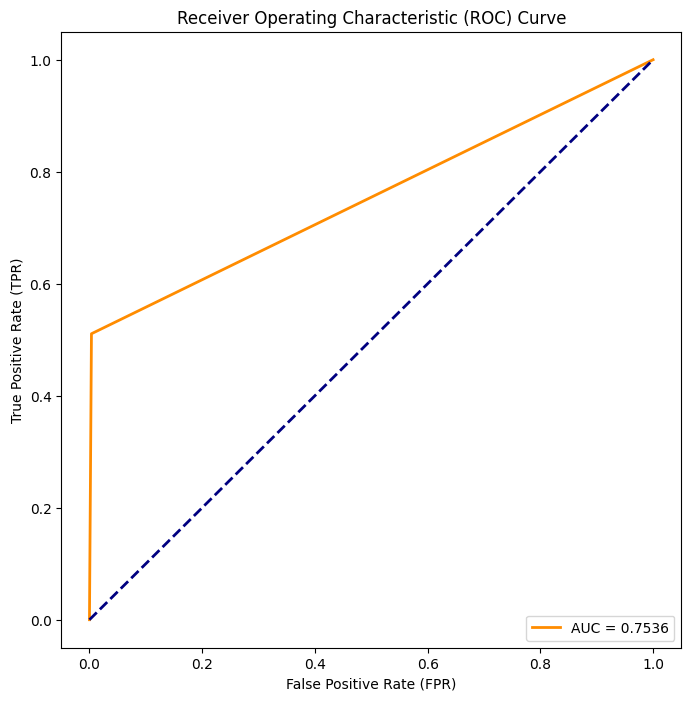

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute the metrics for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_tuned)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [94]:
# Add results to the report
all_reports = performance_report(all_reports, y_train, y_pred_train_tuned, y_test, y_pred_test_tuned, 'Logistic Regression with Tuning')
pd.DataFrame(all_reports)

,Logistic without Tuning,Logistic Regression with Tuning
ROC-AUC Train Set,0.751564,0.751906
ROC-AUC Test Set,0.753124,0.753571


In [95]:
# Best parameters from RandomizedSearchCV
best_params = log_randomcv.best_params_
print("Best Parameters:", best_params)

# Best estimator from RandomizedSearchCV
best_model = log_randomcv.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_best)
print('Best Model ROC-AUC:', roc_auc)
print(classification_report(y_test, y_pred_best))

# Evaluate the ROC-AUC score
result = evaluate_roc_auc(y_test, y_pred_best)
print('Hasil dari Evaluasi:', result)

Best Parameters: {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 1}
Best Model ROC-AUC: 0.7535714724686318
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121463
           1       0.80      0.51      0.62      3323

    accuracy                           0.98    124786
   macro avg       0.89      0.75      0.81    124786
weighted avg       0.98      0.98      0.98    124786

Hasil dari Evaluasi: Decent


### Model Saving

In [96]:
with open('best_log_model.pkl', 'wb') as model_file:
  pickle.dump(best_log_model, model_file)

## Model Inference

Dibuat pada notebook berbeda dengan nama `P1G5_eldi_inf.ipynb`.

## Kesimpulan